In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.inspection import permutation_importance
import os

In [ ]:
def load_financial_macro_data(country):
    """
    Enhanced data loading function with robust error handling and proper data alignment
    """
    try:
        # Define file paths
        stock_path = f'{financial_folder}/{country}_stock.csv'
        macro_path = f'{macro_folder}/{country}_macro.csv'

        print(f"Loading {country} data from:")
        print(f" - Stock data: {stock_path}")
        print(f" - Macro data: {macro_path}")

        # 1. Load stock data with timezone handling
        stock = pd.read_csv(stock_path)
        # Extract date part and convert to timezone-naive
        stock['Date'] = pd.to_datetime(stock['Date'].astype(str).str.split(' ').str[0])
        stock = stock.set_index('Date')

        # 2. Load macroeconomic data
        macro = pd.read_csv(macro_path)
        macro['date'] = pd.to_datetime(macro['date'])
        macro = macro.set_index('date')

        # Print diagnostic information
        print(f"Stock data date range: {stock.index.min()} to {stock.index.max()}")
        print(f"Macro data date range: {macro.index.min()} to {macro.index.max()}")

        # 3. Resample macro data to monthly frequency with forward fill
        # This properly converts quarterly data to monthly
        macro_monthly = macro.resample('MS').ffill()

        # 4. Calculate stock market features BEFORE merging
        stock['return_1m'] = stock['close'].pct_change()
        stock['return_3m'] = stock['close'].pct_change(3)

        # 5. Calculate moving average features
        stock['ma6'] = stock['close'].rolling(window=6).mean()
        stock['ma_deviation'] = (stock['close'] - stock['ma6']) / stock['ma6']
        stock['volatility'] = stock['return_1m'].rolling(window=3).std()

        # 6. Calculate macroeconomic changes BEFORE merging
        for col in ['GDP', 'CPI', 'UNEMPLOYMENT', 'IMPORTS', 'EXPORTS']:
            if col in macro_monthly.columns:
                macro_monthly[f'{col}_change'] = macro_monthly[col].pct_change()

        # 7. Join data with proper approach
        # Use left join to keep all stock dates
        data = stock.join(macro_monthly, how='left')

        # 8. Filter to overlapping date range
        # Only keep dates where both stock and macro data exist
        start_date = max(stock.index.min(), macro.index.min())
        end_date = min(stock.index.max(), macro.index.max())
        data = data[(data.index >= start_date) & (data.index <= end_date)]

        # 9. Handle missing values selectively
        # For regime classification, we need key features, but not all
        key_features = ['return_1m', 'volatility', 'ma_deviation']

        # Only drop rows where key features are missing
        data = data.dropna(subset=key_features)

        # 10. Add regime classification
        data['regime'] = 1  # Default to range-bound/neutral

        # Define bearish and bullish based on price and returns
        bearish = (data['close'] < data['ma6']) & (data['return_3m'] < -0.03)
        bullish = (data['close'] > data['ma6']) & (data['return_3m'] > 0.03)

        data.loc[bearish, 'regime'] = 0  # Bearish
        data.loc[bullish, 'regime'] = 2  # Bullish

        # Additional economic confirmation if data is available
        if 'GDP_change' in data.columns:
            # Reinforce bearish classification
            strong_bearish = (data['GDP_change'] < 0) & (data['regime'] == 0)
            data.loc[strong_bearish, 'regime'] = 0

            # Reinforce bullish classification
            strong_bullish = (data['GDP_change'] > 0) & (data['regime'] == 2)
            data.loc[strong_bullish, 'regime'] = 2

        print(f"Successfully processed data: {len(data)} rows with {data.columns.size} columns")
        print(f"Regime distribution: {data['regime'].value_counts().to_dict()}")

        return data

    except Exception as e:
        import traceback
        print(f"Error processing {country} data: {str(e)}")
        print(traceback.format_exc())
        return pd.DataFrame()  # Return empty DataFrame on error


In [ ]:
def create_correlation_matrix(data):
    """
    Generate correlation matrix and heatmap
    """
    if data is None or len(data) == 0:
        print("No data available for correlation analysis")
        return None

    # Select features
    features = ['return_1m', 'return_3m', 'volatility', 'ma_deviation',
                'GDP_change', 'CPI_change']

    # Create correlation matrix
    corr_matrix = data[features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f',
                cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Correlation with market regime
    if 'regime' in data.columns:
        target_corr = data[features + ['regime']].corr()['regime'].drop('regime')

        plt.figure(figsize=(12, 7))
        target_corr.sort_values().plot(kind='barh', color='skyblue')
        plt.title('Feature Correlation with Market Regime', fontsize=16)
        plt.xlabel('Correlation Coefficient', fontsize=14)
        plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

    return corr_matrix


In [ ]:
def analyze_feature_importance(data):
    """
    Generate Random Forest feature importance chart
    """
    if data is None or len(data) == 0:
        print("No data available for feature importance analysis")
        return None

    # Select features
    features = ['return_1m', 'return_3m', 'volatility', 'ma_deviation',
                'GDP_change', 'CPI_change']

    # Prepare data
    X = data[features]
    y = data['regime']

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=500, random_state=42)
    model.fit(X, y)

    # Get feature importance
    importances = model.feature_importances_

    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=True)

    # Plot feature importance
    plt.figure(figsize=(12, 7))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance', fontsize=14)
    plt.title('Feature Importance from Random Forest Classifier', fontsize=16)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance_df



In [ ]:
def analyze_permutation_importance(data):
    """
    Generate permutation importance plot
    """
    if data is None or len(data) == 0:
        print("No data available for permutation importance analysis")
        return None

    # Select features
    features = ['return_1m', 'return_3m', 'volatility', 'ma_deviation',
                'GDP_change', 'CPI_change']

    # Prepare data
    X = data[features]
    y = data['regime']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                       random_state=42, shuffle=False)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=500, random_state=42)
    model.fit(X_train, y_train)

    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test,
                                           n_repeats=10, random_state=42)

    # Sort features by importance
    indices = perm_importance.importances_mean.argsort()
    sorted_features = [features[i] for i in indices]

    # Plot permutation importance
    plt.figure(figsize=(12, 7))
    plt.boxplot(perm_importance.importances[indices].T, vert=False,
               labels=sorted_features)
    plt.xlabel('Decrease in Model Score', fontsize=14)
    plt.title('Permutation Importances (test set)', fontsize=16)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'Feature': sorted_features,
        'Mean_Importance': perm_importance.importances_mean[indices],
        'Std_Importance': perm_importance.importances_std[indices]
    })


Loading data for brazil...
Macro data: /content/drive/MyDrive/processed_data/brazil_macro.csv
Stock data: /content/drive/MyDrive/financial_info/brazil_stock.csv
Successfully prepared data for brazil: 143 rows
Loading data for india...
Macro data: /content/drive/MyDrive/processed_data/india_macro.csv
Stock data: /content/drive/MyDrive/financial_info/india_stock.csv
Successfully prepared data for india: 143 rows
Loading data for south_africa...
Macro data: /content/drive/MyDrive/processed_data/south_africa_macro.csv
Stock data: /content/drive/MyDrive/financial_info/south_africa_stock.csv
Successfully prepared data for south_africa: 143 rows
Processing Brazil data with 143 rows and 15 columns
Regime distribution: {1: 79, 2: 39, 0: 25}


<ipython-input-5-a30b62ae812a>:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(result.importances[sorted_idx].T, vert=False, labels=sorted_features)


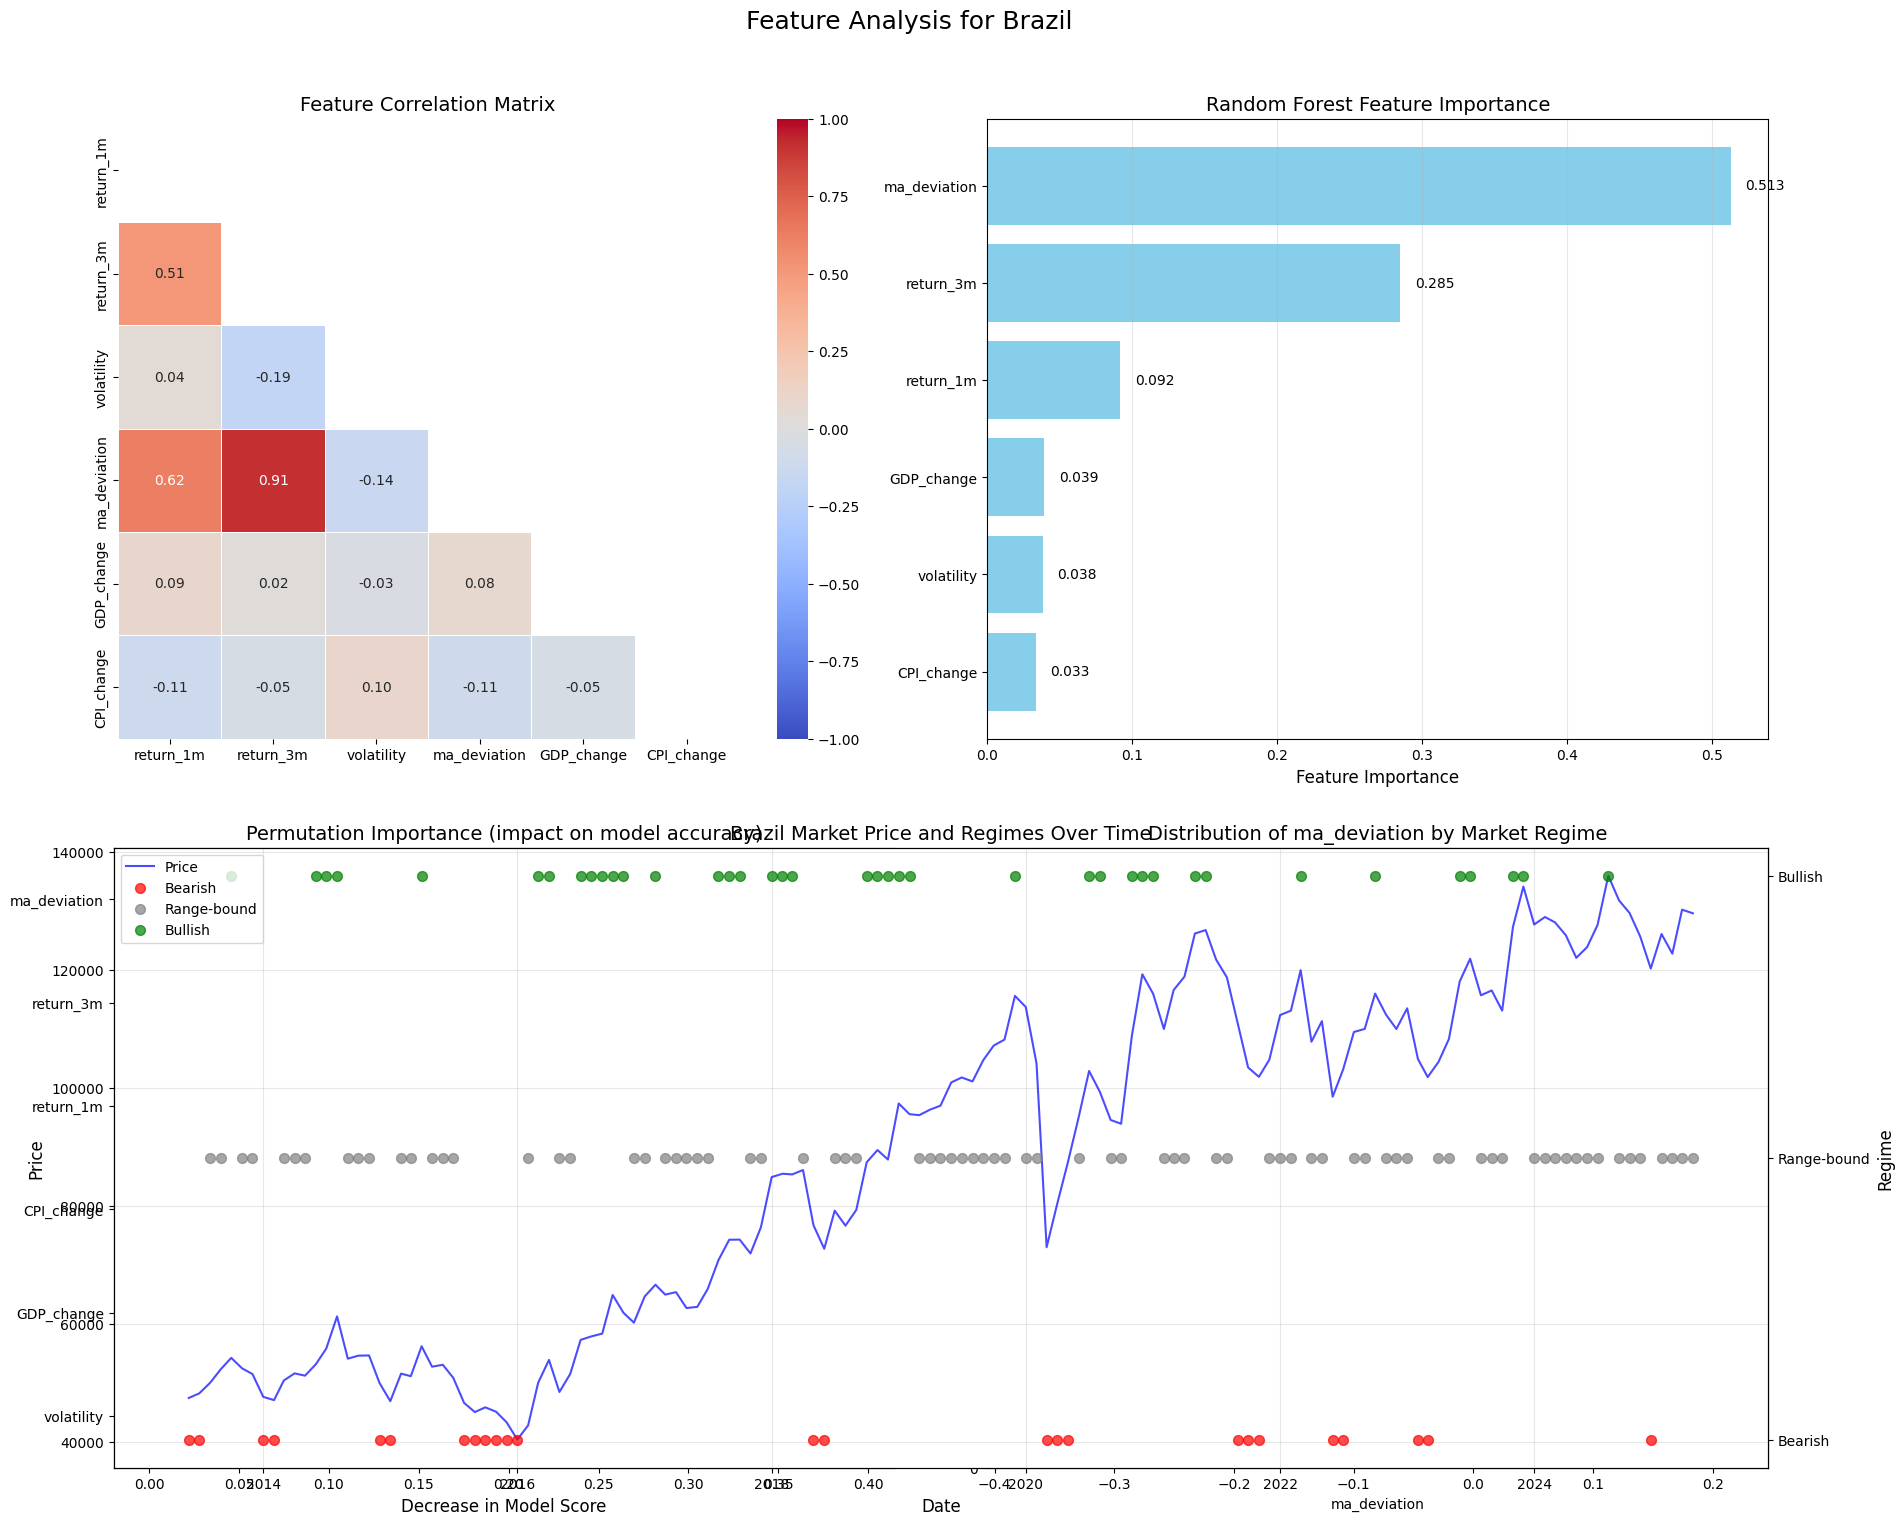


Summary for Brazil:
Analysis completed successfully with 6 features
Model accuracy: 0.97

Top 3 most important features:
1. ma_deviation (importance: 0.513)
2. return_3m (importance: 0.285)
3. return_1m (importance: 0.092)
Processing India data with 143 rows and 15 columns
Regime distribution: {1: 83, 2: 52, 0: 8}


<ipython-input-5-a30b62ae812a>:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(result.importances[sorted_idx].T, vert=False, labels=sorted_features)


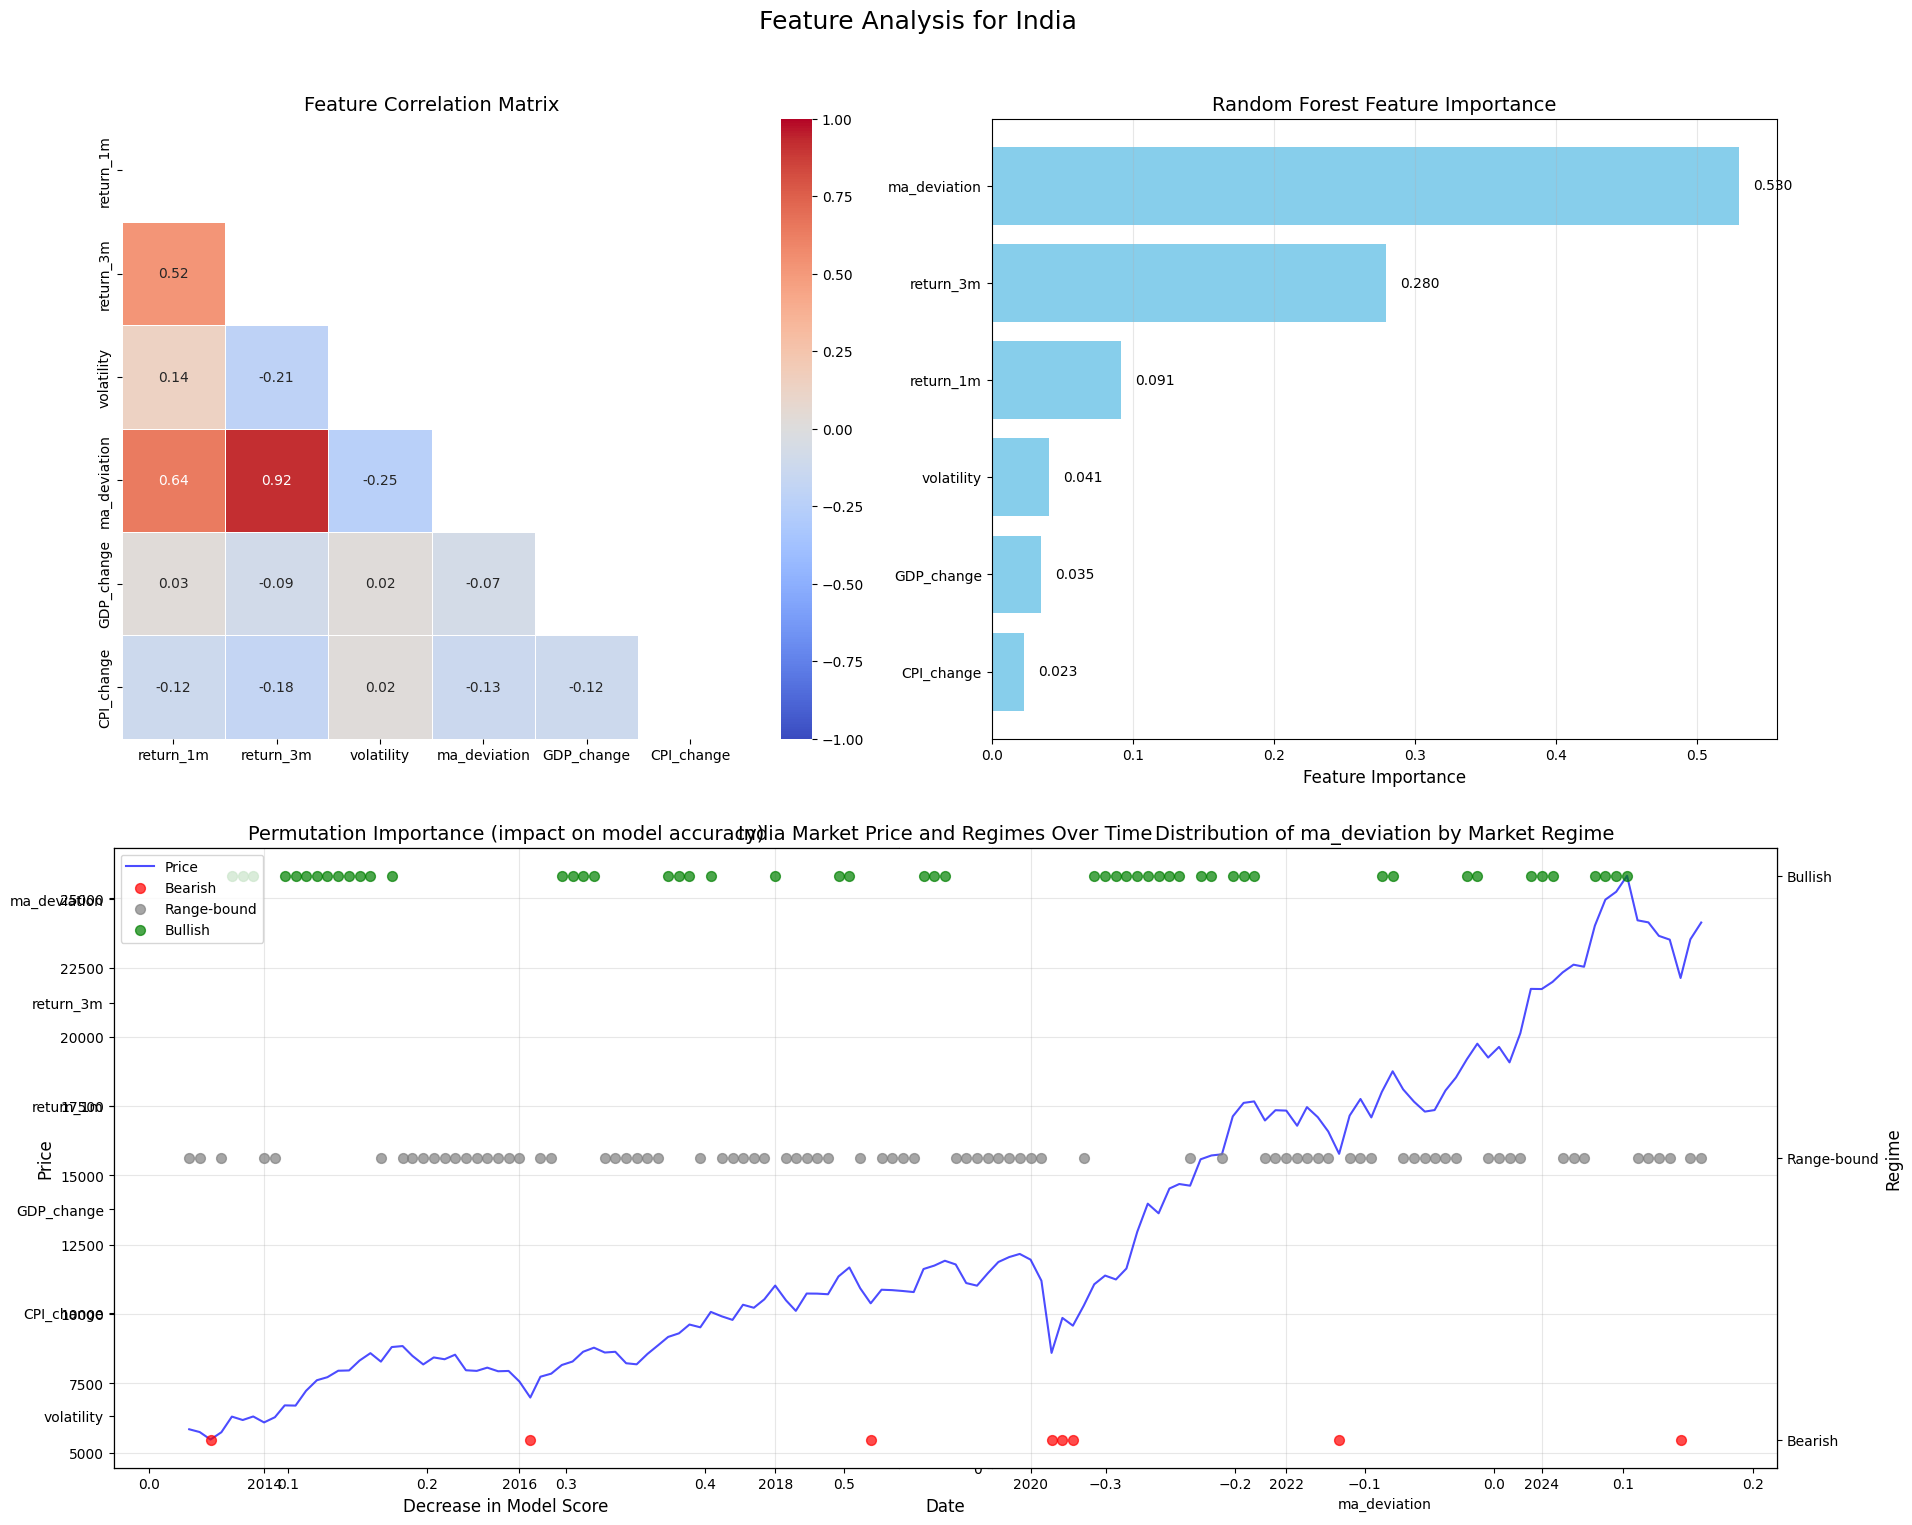


Summary for India:
Analysis completed successfully with 6 features
Model accuracy: 0.97

Top 3 most important features:
1. ma_deviation (importance: 0.530)
2. return_3m (importance: 0.280)
3. return_1m (importance: 0.091)
Processing South_Africa data with 143 rows and 17 columns
Regime distribution: {1: 70, 2: 40, 0: 33}


<ipython-input-5-a30b62ae812a>:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(result.importances[sorted_idx].T, vert=False, labels=sorted_features)


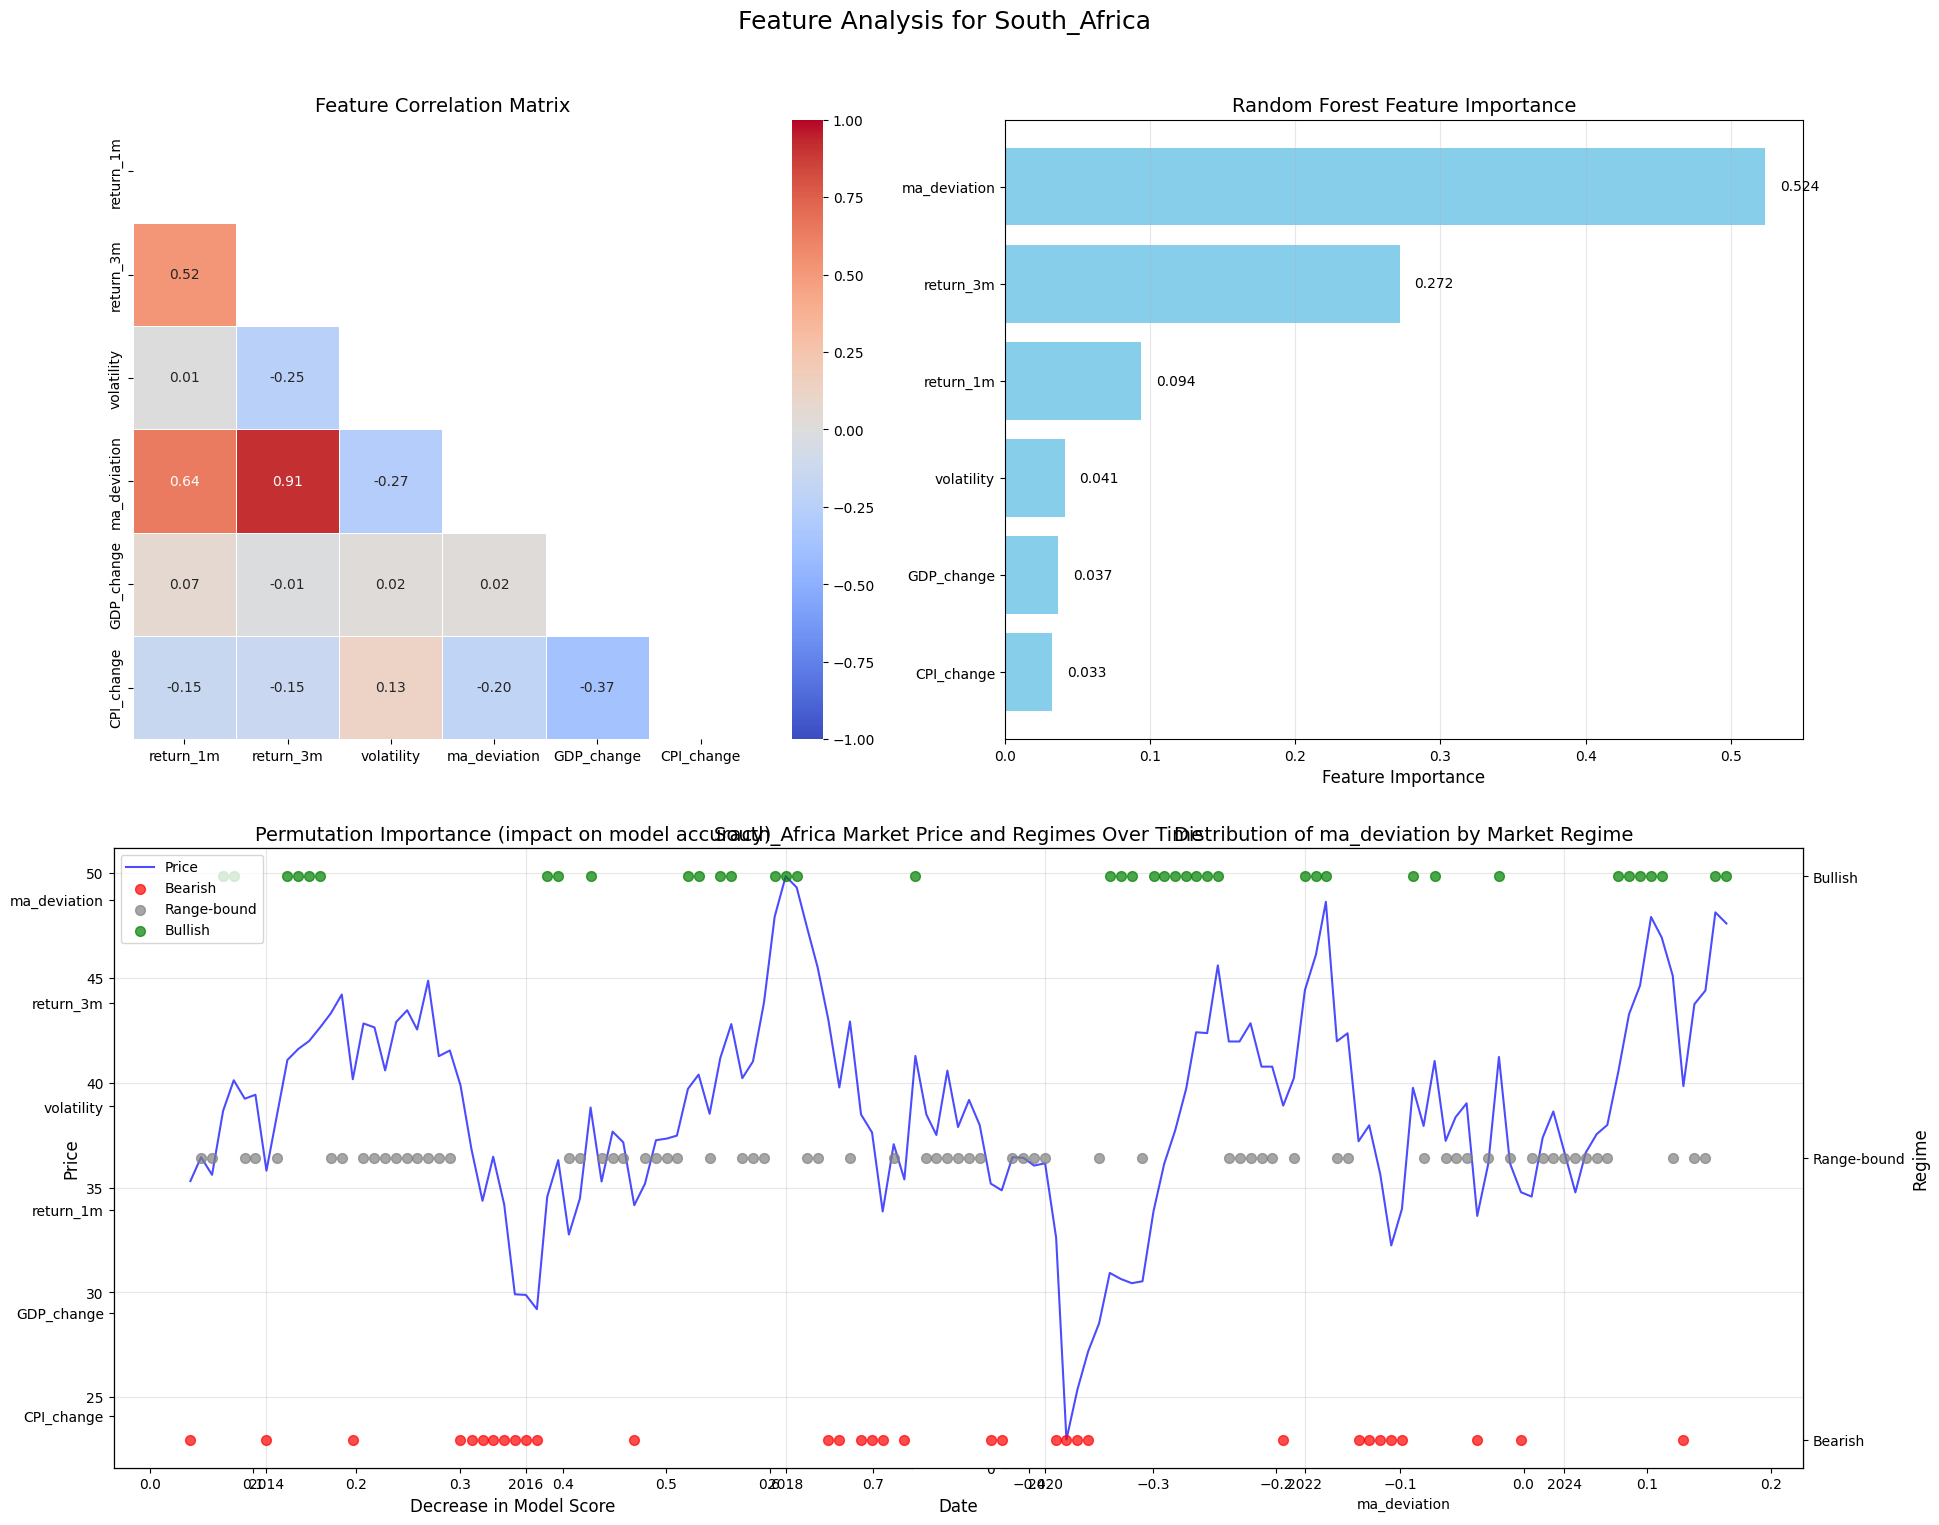


Summary for South_Africa:
Analysis completed successfully with 6 features
Model accuracy: 1.00

Top 3 most important features:
1. ma_deviation (importance: 0.524)
2. return_3m (importance: 0.272)
3. return_1m (importance: 0.094)

Overall Summary:
Brazil: Analysis successful (Accuracy: 0.97)
India: Analysis successful (Accuracy: 0.97)
South_Africa: Analysis successful (Accuracy: 1.00)


In [5]:
def create_feature_analysis_dashboard(data, country_name, save_path=None):
    """
    Create a comprehensive feature analysis dashboard with robust error handling
    and detailed visualizations.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing financial and macroeconomic features with 'regime' column
    country_name : str
        Name of the country for display purposes
    save_path : str, optional
        Path to save the dashboard figure

    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Initialize results dictionary
    results = {
        'country': country_name,
        'success': False,
        'error': None,
        'data_shape': None,
        'feature_importance': None,
        'correlation_matrix': None,
        'permutation_importance': None
    }

    # Validate input data
    if data is None or data.empty:
        results['error'] = f"No data available for {country_name}"
        print(results['error'])
        return results

    results['data_shape'] = data.shape
    print(f"Processing {country_name} data with {data.shape[0]} rows and {data.shape[1]} columns")

    # Check if regime column exists
    if 'regime' not in data.columns:
        results['error'] = f"No 'regime' column found in {country_name} data"
        print(results['error'])
        return results

    # Define potential features and check which ones are available
    potential_features = ['return_1m', 'return_3m', 'volatility', 'ma_deviation',
                         'GDP_change', 'CPI_change', 'INTEREST_RATE_change',
                         'EXCHANGE_RATE_change']

    features = [f for f in potential_features if f in data.columns]

    # Ensure we have at least 2 features
    if len(features) < 2:
        results['error'] = f"Insufficient features for {country_name}. Found only: {features}"
        print(results['error'])
        return results

    # Check if we have enough samples for each regime class
    regime_counts = data['regime'].value_counts()
    print(f"Regime distribution: {regime_counts.to_dict()}")

    if len(regime_counts) < 2:
        results['error'] = f"Insufficient regime classes for {country_name}. Need at least 2 classes."
        print(results['error'])
        return results

    # Set up the figure
    fig = plt.figure(figsize=(20, 16))

    try:
        # Plot 1: Correlation heatmap
        ax1 = fig.add_subplot(2, 2, 1)
        corr_matrix = data[features].corr()
        results['correlation_matrix'] = corr_matrix

        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                   vmin=-1, vmax=1, ax=ax1, cbar=True, square=True, linewidths=0.5)
        ax1.set_title('Feature Correlation Matrix', fontsize=14)

        # Plot 2: Random Forest feature importance
        try:
            # Convert data to numeric to avoid errors
            X = data[features].apply(pd.to_numeric, errors='coerce')
            y = data['regime']

            # Drop rows with NaN values
            valid_indices = ~X.isna().any(axis=1)
            X_clean = X[valid_indices]
            y_clean = y[valid_indices]

            if len(X_clean) < 10:
                raise ValueError(f"Insufficient clean data points ({len(X_clean)}) after removing NaNs")

            # Fit model
            model = RandomForestClassifier(n_estimators=500, random_state=42)
            model.fit(X_clean, y_clean)
            importances = model.feature_importances_

            # Create importance DataFrame
            importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
            importance_df = importance_df.sort_values('Importance', ascending=True)
            results['feature_importance'] = importance_df

            # Plot feature importance
            ax2 = fig.add_subplot(2, 2, 2)
            bars = ax2.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')

            # Add value labels to bars
            for bar in bars:
                width = bar.get_width()
                ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{width:.3f}', ha='left', va='center')

            ax2.set_xlabel('Feature Importance', fontsize=12)
            ax2.set_title('Random Forest Feature Importance', fontsize=14)
            ax2.grid(axis='x', alpha=0.3)

            # Plot 3: Permutation importance
            # Use a smaller test set to speed up computation
            X_train, X_test, y_train, y_test = train_test_split(
                X_clean, y_clean, test_size=min(0.3, 100/len(X_clean)),
                random_state=42, shuffle=False, stratify=None)

            # Fit model on training data
            model.fit(X_train, y_train)

            # Calculate permutation importance
            result = permutation_importance(model, X_test, y_test,
                                          n_repeats=10, random_state=42)

            # Sort features by importance
            sorted_idx = result.importances_mean.argsort()
            sorted_features = np.array(features)[sorted_idx]

            # Store results
            perm_importance_df = pd.DataFrame({
                'Feature': sorted_features,
                'Importance': result.importances_mean[sorted_idx],
                'Std': result.importances_std[sorted_idx]
            })
            results['permutation_importance'] = perm_importance_df

            # Plot permutation importance
            ax3 = fig.add_subplot(2, 2, 3)
            ax3.boxplot(result.importances[sorted_idx].T, vert=False, labels=sorted_features)
            ax3.set_title('Permutation Importance (impact on model accuracy)', fontsize=14)
            ax3.set_xlabel('Decrease in Model Score', fontsize=12)
            ax3.grid(axis='x', alpha=0.3)

            # Plot 4: Feature distribution by regime
            ax4 = fig.add_subplot(2, 2, 4)

            # Find the most important feature
            top_feature = importance_df.iloc[-1]['Feature']

            # Use a color palette for regimes
            palette = {0: 'red', 1: 'gray', 2: 'green'}
            regime_names = {0: 'Bearish', 1: 'Range-bound', 2: 'Bullish'}

            # Plot distribution of top feature by regime
            for regime in sorted(regime_counts.index):
                regime_data = data[data['regime'] == regime]
                if len(regime_data) > 0:
                    sns.kdeplot(regime_data[top_feature].astype(float),
                               label=regime_names.get(regime, f"Regime {regime}"),
                               ax=ax4, color=palette.get(regime))

            ax4.set_title(f'Distribution of {top_feature} by Market Regime', fontsize=14)
            ax4.legend(title='Market Regime')
            ax4.grid(alpha=0.3)

            # Add a fifth plot: Time series of regimes
            ax5 = fig.add_subplot(2, 1, 2)

            # Plot stock price
            ax5.plot(data.index, data['close'], 'b-', alpha=0.7, label='Price')

            # Create a second y-axis for regimes
            ax_regime = ax5.twinx()

            # Plot regimes as scatter points with colors
            for regime, color in palette.items():
                regime_data = data[data['regime'] == regime]
                if not regime_data.empty:
                    ax_regime.scatter(regime_data.index, [regime] * len(regime_data),
                                     label=regime_names.get(regime, f"Regime {regime}"),
                                     color=color, s=50, alpha=0.7)

            ax5.set_title(f'{country_name} Market Price and Regimes Over Time', fontsize=14)
            ax5.set_xlabel('Date', fontsize=12)
            ax5.set_ylabel('Price', fontsize=12)
            ax_regime.set_ylabel('Regime', fontsize=12)
            ax_regime.set_yticks([0, 1, 2])
            ax_regime.set_yticklabels(['Bearish', 'Range-bound', 'Bullish'])

            # Combine legends
            lines, labels = ax5.get_legend_handles_labels()
            lines2, labels2 = ax_regime.get_legend_handles_labels()
            ax_regime.legend(lines + lines2, labels + labels2, loc='upper left')

            ax5.grid(True, alpha=0.3)

            # Mark the analysis as successful
            results['success'] = True
            results['accuracy'] = model.score(X_test, y_test)

        except Exception as e:
            print(f"Error in Random Forest analysis: {str(e)}")
            import traceback
            traceback.print_exc()

            # Create empty plots with error messages
            for i, title in enumerate(['Random Forest Importance', 'Permutation Importance',
                                      'Feature Distribution']):
                ax = fig.add_subplot(2, 2, i+2)
                ax.text(0.5, 0.5, f"Error in {title}:\n{str(e)}",
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f"{title} (ERROR)", fontsize=14)

        # Adjust layout and add title
        plt.suptitle(f'Feature Analysis for {country_name}', fontsize=18, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save figure if path is provided
        if save_path:
            plt.savefig(f"{save_path}/{country_name}_feature_analysis.png",
                       dpi=300, bbox_inches='tight')

        plt.show()

    except Exception as e:
        results['error'] = str(e)
        print(f"Error creating dashboard for {country_name}: {str(e)}")
        import traceback
        traceback.print_exc()

    # Print summary
    print(f"\nSummary for {country_name}:")
    if results['success']:
        print(f"Analysis completed successfully with {len(features)} features")
        print(f"Model accuracy: {results.get('accuracy', 'N/A'):.2f}")

        # Print top features by importance
        if results['feature_importance'] is not None:
            top_features = results['feature_importance'].sort_values('Importance', ascending=False)
            print("\nTop 3 most important features:")
            for i, (_, row) in enumerate(top_features.head(3).iterrows()):
                print(f"{i+1}. {row['Feature']} (importance: {row['Importance']:.3f})")
    else:
        print(f"Analysis failed: {results['error']}")

    return results

# Function to load and prepare data for each country
def load_and_prepare_data(country):
    """Load and prepare data for a specific country"""
    # Define paths
    macro_folder = '/content/drive/MyDrive/processed_data'
    financial_folder = '/content/drive/MyDrive/financial_info'

    try:
        # Define file paths
        macro_path = f"{macro_folder}/{country}_macro.csv"
        stock_path = f"{financial_folder}/{country}_stock.csv"

        print(f"Loading data for {country}...")
        print(f"Macro data: {macro_path}")
        print(f"Stock data: {stock_path}")

        # Load macro data
        macro_df = pd.read_csv(macro_path)
        macro_df['date'] = pd.to_datetime(macro_df['date'])

        # Clean duplicate columns in macro data
        clean_macro = pd.DataFrame()
        clean_macro['date'] = macro_df['date']

        # Process each base column name (removing _x and _y duplicates)
        processed_cols = set()
        for col in macro_df.columns:
            if col == 'date':
                continue

            # Get base column name without suffix
            base_col = col.split('_')[0]

            # Skip if already processed this base column
            if base_col in processed_cols:
                continue

            # Choose the non-suffixed version first, then _x, then _y
            if base_col in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[base_col], errors='coerce')
            elif f"{base_col}_x" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_x"], errors='coerce')
            elif f"{base_col}_y" in macro_df.columns:
                clean_macro[base_col] = pd.to_numeric(macro_df[f"{base_col}_y"], errors='coerce')

            processed_cols.add(base_col)

        # Load stock data with proper handling of empty first row
        with open(stock_path, 'r') as f:
            first_line = f.readline().strip()

        skip_rows = 1 if first_line == '' or ',^' in first_line or ',EZA' in first_line else 0
        stock_df = pd.read_csv(stock_path, skiprows=skip_rows)

        # Handle column case sensitivity
        date_col = 'Date' if 'Date' in stock_df.columns else 'date'
        close_col = 'Close' if 'Close' in stock_df.columns else 'close'

        # Create standardized stock dataframe
        stock_clean = pd.DataFrame()
        stock_clean['date'] = pd.to_datetime(stock_df[date_col])
        stock_clean['close'] = pd.to_numeric(stock_df[close_col], errors='coerce')

        # Remove timezone information if present
        if hasattr(stock_clean['date'].dt, 'tz') and stock_clean['date'].dt.tz is not None:
            stock_clean['date'] = stock_clean['date'].dt.tz_localize(None)

        # Set date as index for both dataframes
        clean_macro.set_index('date', inplace=True)
        stock_clean.set_index('date', inplace=True)

        # Calculate technical indicators
        stock_clean['return_1m'] = stock_clean['close'].pct_change()
        stock_clean['return_3m'] = stock_clean['close'].pct_change(3)
        stock_clean['volatility'] = stock_clean['return_1m'].rolling(window=3).std()

        # Calculate moving averages
        stock_clean['ma6'] = stock_clean['close'].rolling(window=6).mean()
        stock_clean['ma_deviation'] = (stock_clean['close'] - stock_clean['ma6']) / stock_clean['ma6']

        # Calculate macroeconomic changes
        for col in ['GDP', 'CPI', 'UNEMPLOYMENT', 'IMPORTS', 'EXPORTS', 'INTEREST_RATE', 'EXCHANGE_RATE']:
            if col in clean_macro.columns:
                clean_macro[f'{col}_change'] = clean_macro[col].pct_change()

        # Resample macro data to monthly frequency with forward fill
        macro_monthly = clean_macro.resample('MS').ffill()

        # Merge data
        data = stock_clean.join(macro_monthly, how='left')

        # Add regime classification
        data['regime'] = 1  # Default to range-bound/neutral

        # Define bearish and bullish based on price and returns
        bearish = (data['ma_deviation'] < -0.05) & (data['return_3m'] < -0.03)
        bullish = (data['ma_deviation'] > 0.05) & (data['return_3m'] > 0.03)

        data.loc[bearish, 'regime'] = 0  # Bearish
        data.loc[bullish, 'regime'] = 2  # Bullish

        # Additional economic confirmation if data is available
        if 'GDP_change' in data.columns:
            # Reinforce bearish classification
            strong_bearish = (data['GDP_change'] < 0) & (data['regime'] == 0)
            data.loc[strong_bearish, 'regime'] = 0

            # Reinforce bullish classification
            strong_bullish = (data['GDP_change'] > 0) & (data['regime'] == 2)
            data.loc[strong_bullish, 'regime'] = 2

        # Drop rows with NaN in essential columns
        essential_cols = ['return_1m', 'return_3m', 'volatility', 'ma_deviation']
        data = data.dropna(subset=essential_cols)

        print(f"Successfully prepared data for {country}: {len(data)} rows")
        return data

    except Exception as e:
        print(f"Error preparing data for {country}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Create output directory
output_dir = '/content/drive/MyDrive/feature_analysis_output'
os.makedirs(output_dir, exist_ok=True)

# Process each country
countries = ['brazil', 'india', 'south_africa']
country_data = {}

for country in countries:
    country_data[country] = load_and_prepare_data(country)

# Run feature analysis for each country
results = {}
for country, data in country_data.items():
    if data is not None and not data.empty:
        results[country] = create_feature_analysis_dashboard(data, country.title(), save_path=output_dir)
    else:
        print(f"Skipping analysis for {country} due to data loading issues")
        results[country] = {'country': country, 'success': False, 'error': 'Data loading failed'}

# Print overall summary
print("\nOverall Summary:")
for country, result in results.items():
    if result.get('success', False):
        print(f"{country.title()}: Analysis successful (Accuracy: {result.get('accuracy', 'N/A'):.2f})")
    else:
        print(f"{country.title()}: Analysis failed - {result.get('error', 'Unknown error')}")


